# Causal Inference

In this project, I explored the relationship between financial news sentiment and its potential impact on stock prices by implementing a sentiment analysis model. By leveraging natural language processing (NLP) techniques, we utilized both VADER and TextBlob sentiment analyzers, with an enhancement to VADER’s lexicon to incorporate financial terms. This customization allowed the model to better capture the nuances of financial language, such as terms like "bullish," "bearish," "rally," and "plunge."

**While sentiment analysis is a powerful tool, this study found no clear causal link between financial news sentiment and stock returns.** Future research should explore more granular data, advanced modeling, and sector-specific relationships to uncover potential predictive power.

In [1]:
import pandas as pd
import zipfile
from datetime import datetime
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import time
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
# Path to your zip file (update this with your actual path)
zip_path = 'Financial News Headlines.zip'

# Function to load and inspect each CSV file
def load_and_inspect_csv(zip_file, csv_name):
    with zip_file.open(csv_name) as f:
        df = pd.read_csv(f)
    
    print(f"\n=== {csv_name} ===")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nInfo:")
    print(df.info())
    print("\nDescribe:")
    print(df.describe())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # If there's a date column, check the date range
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    if date_cols:
        df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], errors='coerce')
        print(f"\nDate range: {df[date_cols[0]].min()} to {df[date_cols[0]].max()}")
    
    return df

# Load and inspect each file
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # List files in the zip
    print("Files in the zip archive:")
    print(zip_file.namelist())
    
    # Load each CSV
    cnbc_df = load_and_inspect_csv(zip_file, 'cnbc_headlines.csv')
    guardian_df = load_and_inspect_csv(zip_file, 'guardian_headlines.csv')
    reuters_df = load_and_inspect_csv(zip_file, 'reuters_headlines.csv')

Files in the zip archive:
['cnbc_headlines.csv', 'guardian_headlines.csv', 'reuters_headlines.csv']

=== cnbc_headlines.csv ===
Shape: (3080, 3)

First 5 rows:
                                           Headlines  \
0  Jim Cramer: A better way to invest in the Covi...   
1     Cramer's lightning round: I would own Teradyne   
2                                                NaN   
3  Cramer's week ahead: Big week for earnings, ev...   
4  IQ Capital CEO Keith Bliss says tech and healt...   

                             Time  \
0   7:51  PM ET Fri, 17 July 2020   
1   7:33  PM ET Fri, 17 July 2020   
2                             NaN   
3   7:25  PM ET Fri, 17 July 2020   
4   4:24  PM ET Fri, 17 July 2020   

                                         Description  
0  "Mad Money" host Jim Cramer recommended buying...  
1  "Mad Money" host Jim Cramer rings the lightnin...  
2                                                NaN  
3  "We'll pay more for the earnings of the non-Co...  
4  Ke

## Clean Data

In [3]:
def parse_guardian_date(date_str):
    """Flexible date parser for Guardian's various date formats"""
    try:
        # Try the original format (e.g., "18-Jul-20")
        return datetime.strptime(date_str, "%d-%b-%y").date()
    except ValueError:
        try:
            # Try format without century (e.g., "18-Jul-2020")
            return datetime.strptime(date_str, "%d-%b-%Y").date()
        except ValueError:
            try:
                # Try month-first format (e.g., "Jul-18")
                return datetime.strptime(date_str, "%b-%d").date().replace(year=datetime.now().year)
            except ValueError:
                # If all fails, return None (will be filtered out later)
                return None

def clean_cnbc_data(df):
    """Clean CNBC headlines data"""
    df = df.copy()
    
    # Drop rows with all NA values
    df = df.dropna(how='all')
    
    # Parse datetime with multiple format attempts
    df['datetime'] = pd.to_datetime(
        df['Time'],
        errors='coerce',
        format='%I:%M %p ET %a, %d %B %Y'
    )
    
    # For rows where parsing failed, try alternative formats
    mask = df['datetime'].isna()
    if mask.any():
        # Try format without ET
        df.loc[mask, 'datetime'] = pd.to_datetime(
            df.loc[mask, 'Time'].str.replace(' ET', ''),
            errors='coerce',
            format='%I:%M %p %a, %d %B %Y'
        )
    
    # Drop rows where datetime couldn't be parsed
    df = df.dropna(subset=['datetime'])
    
    # Create date column
    df['date'] = df['datetime'].dt.date
    
    # Clean text columns
    text_cols = ['Headlines', 'Description']
    for col in text_cols:
        df[col] = df[col].fillna('').astype(str)
        df[col] = df[col].str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    
    return df.drop(columns=['Time', 'datetime'])

def clean_guardian_data(df):
    """Clean Guardian headlines data with robust date parsing"""
    df = df.copy()
    
    # Apply flexible date parser
    df['date'] = df['Time'].apply(parse_guardian_date)
    
    # Drop rows where date couldn't be parsed
    df = df.dropna(subset=['date'])
    
    # Clean headlines
    df['Headlines'] = df['Headlines'].astype(str).str.strip()
    df['Headlines'] = df['Headlines'].str.replace(r'\s+', ' ', regex=True)
    df['Headlines'] = df['Headlines'].str.replace(r'\n', ' ', regex=True)
    
    return df.drop(columns=['Time'])

def clean_reuters_data(df):
    """Clean Reuters headlines data"""
    df = df.copy()
    
    # Convert Time to datetime
    df['date'] = pd.to_datetime(
        df['Time'],
        format='%b %d %Y',
        errors='coerce'
    ).dt.date
    
    # Drop rows where date couldn't be parsed
    df = df.dropna(subset=['date'])
    
    # Clean text columns
    text_cols = ['Headlines', 'Description']
    for col in text_cols:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    
    return df.drop(columns=['Time'])

def standardize_dataframes(cnbc, guardian, reuters):
    """Standardize all dataframes to common format"""
    cnbc = cnbc.copy()
    guardian = guardian.copy()
    reuters = reuters.copy()
    
    # Create consistent column names and structure
    cnbc = cnbc[['date', 'Headlines', 'Description']]
    guardian = guardian[['date', 'Headlines']]
    reuters = reuters[['date', 'Headlines', 'Description']]
    
    # Add source identifier
    cnbc['source'] = 'CNBC'
    guardian['source'] = 'Guardian'
    reuters['source'] = 'Reuters'
    
    # For Guardian which lacks Description, create empty column
    guardian['Description'] = ''
    
    # Ensure consistent order
    final_cols = ['date', 'source', 'Headlines', 'Description']
    return (
        cnbc[final_cols],
        guardian[final_cols],
        reuters[final_cols]
    )

def merge_datasets(cnbc, guardian, reuters):
    """Merge all datasets into one unified dataframe"""
    return pd.concat([cnbc, guardian, reuters], ignore_index=True)

# Load your original data
# Clean each dataset
cnbc_clean = clean_cnbc_data(cnbc_df)
guardian_clean = clean_guardian_data(guardian_df)
reuters_clean = clean_reuters_data(reuters_df)

# Standardize formats
cnbc_std, guardian_std, reuters_std = standardize_dataframes(cnbc_clean, guardian_clean, reuters_clean)

# Merge datasets
all_news = merge_datasets(cnbc_std, guardian_std, reuters_std)

# Final cleaning on merged data
all_news = all_news.sort_values('date')
all_news = all_news.drop_duplicates(subset=['date', 'source', 'Headlines'])

print("\nCleaned data overview:")
print(f"Total articles: {len(all_news)}")
print(f"Date range: {all_news['date'].min()} to {all_news['date'].max()}")
print("\nSample of cleaned data:")
print(all_news.head())


Cleaned data overview:
Total articles: 50610
Date range: 2017-12-17 to 2025-07-18

Sample of cleaned data:
             date    source  \
17900  2017-12-17  Guardian   
17899  2017-12-17  Guardian   
17901  2017-12-17  Guardian   
17902  2017-12-17  Guardian   
17903  2017-12-17  Guardian   

                                               Headlines Description  
17900  Why business could prosper under a Corbyn gove...              
17899  Peter Preston on press and broadcasting Paul D...              
17901  Youngest staff to be given UK workplace pensio...              
17902  Grogonomics This year has been about companies...              
17903  Butchers carve out a niche as UK shoppers opt ...              


In [4]:
# Check date parsing success rate
print(f"CNBC kept {len(cnbc_clean)}/{len(cnbc_df)} rows ({len(cnbc_clean)/len(cnbc_df):.1%})")
print(f"Guardian kept {len(guardian_clean)}/{len(guardian_df)} rows ({len(guardian_clean)/len(guardian_df):.1%})")
print(f"Reuters kept {len(reuters_clean)}/{len(reuters_df)} rows ({len(reuters_clean)/len(reuters_df):.1%})")

# Check for remaining issues
print("\nDate ranges:")
print("CNBC:", cnbc_clean['date'].min(), "to", cnbc_clean['date'].max())
print("Guardian:", guardian_clean['date'].min(), "to", guardian_clean['date'].max())
print("Reuters:", reuters_clean['date'].min(), "to", reuters_clean['date'].max())

# Check final merged data
print("\nMerged data info:")
print(all_news.info())
print("\nMissing values:")
print(all_news.isnull().sum())

CNBC kept 119/3080 rows (3.9%)
Guardian kept 17800/17800 rows (100.0%)
Reuters kept 32770/32770 rows (100.0%)

Date ranges:
CNBC: 2018-03-05 to 2020-07-02
Guardian: 2017-12-17 to 2025-07-18
Reuters: 2018-03-20 to 2020-07-18

Merged data info:
<class 'pandas.core.frame.DataFrame'>
Index: 50610 entries, 17900 to 14040
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         50610 non-null  object
 1   source       50610 non-null  object
 2   Headlines    50610 non-null  object
 3   Description  50610 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

Missing values:
date           0
source         0
Headlines      0
Description    0
dtype: int64


In [5]:
# CNBC

def clean_cnbc_data(df):
    """Improved CNBC headlines data cleaner"""
    df = df.copy()
    df = df.dropna(how='all')
    
    # Initialize datetime column
    df['datetime'] = pd.NaT
    
    # List of possible CNBC date formats to try
    date_formats = [
        '%I:%M %p ET %a, %d %B %Y',  # "7:51 PM ET Fri, 17 July 2020"
        '%I:%M %p %a, %d %B %Y',      # "7:51 PM Fri, 17 July 2020" (no ET)
        '%a, %d %B %Y %I:%M %p ET',   # "Fri, 17 July 2020 7:51 PM ET"
        '%B %d, %Y %I:%M %p ET',      # "July 17, 2020 7:51 PM ET"
        '%d-%b-%y %I:%M %p ET',       # "17-Jul-20 7:51 PM ET"
    ]
    
    # Try each format until we find one that works
    for fmt in date_formats:
        mask = df['datetime'].isna()
        if not mask.any():
            break
        df.loc[mask, 'datetime'] = pd.to_datetime(
            df.loc[mask, 'Time'],
            errors='coerce',
            format=fmt
        )
    
    # For remaining NA values, try parsing without time
    mask = df['datetime'].isna()
    if mask.any():
        df.loc[mask, 'datetime'] = pd.to_datetime(
            df.loc[mask, 'Time'],
            errors='coerce'
        )
    
    # Drop rows where datetime couldn't be parsed
    df = df.dropna(subset=['datetime'])
    df['date'] = df['datetime'].dt.date
    
    # Clean text columns
    text_cols = ['Headlines', 'Description']
    for col in text_cols:
        df[col] = df[col].fillna('').astype(str)
        df[col] = df[col].str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    
    return df.drop(columns=['Time', 'datetime'])

def fix_guardian_dates(df):
    """Ensure Guardian dates are properly parsed (fix future dates)"""
    df = df.copy()
    current_year = datetime.now().year
    
    # Convert dates to datetime if they're strings
    if df['date'].dtype == object:
        df['date'] = pd.to_datetime(df['date']).dt.date
    
    # Fix dates in the future (likely 2-digit year misinterpretation)
    future_mask = df['date'].apply(lambda x: x.year > current_year)
    df.loc[future_mask, 'date'] = df.loc[future_mask, 'date'].apply(
        lambda x: x.replace(year=x.year - 100) if x.year > current_year else x
    )
    
    return df

## Sentiment Analysis with VADER & TextBlob

In [ ]:
# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

- The calculate_sentiment(text) function extracts sentiment scores using VADER and TextBlob.
- VADER provides scores like compound, positive, and negative sentiment.
- TextBlob gives polarity (how positive/negative a sentence is) and subjectivity (how opinion-based it is).

In [ ]:
def calculate_sentiment(text):
    """Calculate multiple sentiment scores for a given text"""
    if pd.isna(text) or text.strip() == '':
        return {
            'vader_compound': np.nan,
            'vader_pos': np.nan,
            'vader_neg': np.nan,
            'textblob_polarity': np.nan,
            'textblob_subjectivity': np.nan
        }
    
    # VADER sentiment
    vader_sentiment = vader_analyzer.polarity_scores(text)
    
    # TextBlob sentiment
    blob = TextBlob(text)
    
    return {
        'vader_compound': vader_sentiment['compound'],
        'vader_pos': vader_sentiment['pos'],
        'vader_neg': vader_sentiment['neg'],
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity
    }


The function process_sentiment_data(news_df) loops through the news dataset, applies calculate_sentiment() to each row, and aggregates daily sentiment scores across different news sources.

In [ ]:
def process_sentiment_data(news_df):
    """Process sentiment data and return daily averages"""
    print("Calculating sentiment scores...")
    sentiment_results = []
    
    for _, row in tqdm(news_df.iterrows(), total=len(news_df)):
        headline_sentiment = calculate_sentiment(row['Headlines'])
        desc_sentiment = calculate_sentiment(row['Description']) if pd.notna(row['Description']) else None
        
        result = {
            'date': row['date'],
            'source': row['source'],
            'headline_vader': headline_sentiment['vader_compound'],
            'headline_textblob': headline_sentiment['textblob_polarity'],
            'desc_vader': desc_sentiment['vader_compound'] if desc_sentiment else np.nan,
            'desc_textblob': desc_sentiment['textblob_polarity'] if desc_sentiment else np.nan
        }
        sentiment_results.append(result)
    
    sentiment_df = pd.DataFrame(sentiment_results)
    
    # Aggregate sentiment by day (average across all news sources)
    daily_sentiment = sentiment_df.groupby('date').agg({
        'headline_vader': 'mean',
        'headline_textblob': 'mean',
        'desc_vader': 'mean',
        'desc_textblob': 'mean'
    }).reset_index()
    
    return daily_sentiment

get_stock_data(start_date, end_date, ticker='^GSPC') pulls historical closing prices of the S&P 500 from Yahoo Finance (yfinance).

In [ ]:
def get_stock_data(start_date, end_date, ticker='^GSPC'):
    """Download and process stock market data"""
    print("\nDownloading stock market data...")
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data.reset_index()
    stock_data['date'] = stock_data['Date'].dt.date
    stock_data = stock_data[['date', 'Close']].rename(columns={'Close': 'sp500_close'})
    stock_data['sp500_return'] = stock_data['sp500_close'].pct_change() * 100  # percentage returns
    return stock_data.dropna()

It then computes daily returns in percentage (sp500_return).

In [ ]:
def prepare_merged_data(sentiment_df, stock_df):
    """Merge and prepare data for analysis"""
    # Ensure columns are single-level
    sentiment_df.columns = sentiment_df.columns.get_level_values(0) if isinstance(sentiment_df.columns, pd.MultiIndex) else sentiment_df.columns
    stock_df.columns = stock_df.columns.get_level_values(0) if isinstance(stock_df.columns, pd.MultiIndex) else stock_df.columns
    
    # Convert to pandas Series if needed
    if isinstance(sentiment_df, pd.Series):
        sentiment_df = sentiment_df.to_frame()
    if isinstance(stock_df, pd.Series):
        stock_df = stock_df.to_frame()
        
    # Ensure date is the index for both DataFrames
    sentiment_ts = sentiment_df.set_index('date')
    stock_ts = stock_df.set_index('date')
    
    # Merge using inner join to only keep dates with both sentiment and stock data
    merged_data = pd.merge(
        sentiment_ts,
        stock_ts,
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # Drop any remaining NA values
    merged_data = merged_data.dropna()
    
    if len(merged_data) < 50:
        raise ValueError("Insufficient data points for analysis (need at least 50)")
    
    return merged_data


The run_granger_tests(data, x_col, y_col, max_lag=7) applies the Granger causality test to determine if past sentiment values help predict future stock returns.

In [ ]:
def run_granger_tests(data, x_col, y_col, max_lag=7):
    """Run Granger causality tests in both directions"""
    print(f"\nGranger causality tests (does {x_col} cause {y_col}?):")
    gc_results = grangercausalitytests(data[[y_col, x_col]], max_lag, verbose=False)
    
    print(f"\nGranger causality p-values (H0: {x_col} does not Granger-cause {y_col}):")
    for lag in range(1, max_lag+1):
        p_value = gc_results[lag][0]['ssr_ftest'][1]
        print(f"Lag {lag}: p-value = {p_value:.4f} {'*' if p_value < 0.05 else ''}")
    
    return gc_results


Granger causality requires time series to be stationary (constant mean and variance over time).

In [ ]:
def check_stationarity(data):
    """Check stationarity of time series"""
    print("\nStationarity tests:")
    for col in data.columns:
        result = adfuller(data[col].dropna())
        print(f"{col} ADF p-value: {result[1]:.4f}")
        if result[1] > 0.05:
            print(f"Warning: {col} may not be stationary - consider differencing")


### Visualizing the Results

In [ ]:
def visualize_results(data):
    """Create visualizations of the results"""
    plt.figure(figsize=(14, 10))
    
    # Plot sentiment and returns over time
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['headline_vader'], label='Sentiment (Vader)')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment and Stock Returns Over Time')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['sp500_return'], color='orange', label='S&P 500 Daily Returns')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    
    # Plot cross-correlation
    plt.subplot(3, 1, 3)
    pd.plotting.autocorrelation_plot(data['headline_vader'], label='Sentiment Autocorrelation')
    pd.plotting.autocorrelation_plot(data['sp500_return'], label='Returns Autocorrelation')
    plt.legend()
    plt.xlabel('Lag (days)')
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plot of sentiment vs next-day returns
    data['next_day_return'] = data['sp500_return'].shift(-1)
    plt.figure(figsize=(10, 6))
    sns.regplot(x='headline_vader', y='next_day_return', data=data, scatter_kws={'alpha':0.5})
    plt.title('Current Day Sentiment vs Next Day Returns')
    plt.xlabel('Sentiment Score (Vader)')
    plt.ylabel('Next Day S&P 500 Return (%)')
    plt.show()

### Running the Full Analysis

This function pipeline includes:

1. Computes sentiment from headlines.
2. Fetches stock price data.
3. Merges the datasets.
4. Checks stationarity.
5. Runs Granger causality tests.
6. Visualizes results.

Calculating sentiment scores...


100%|██████████| 50610/50610 [00:22<00:00, 2219.93it/s]


[*********************100%***********************]  1 of 1 completed
C:\Users\milto\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Stationarity tests:
headline_vader ADF p-value: 0.0000
sp500_return ADF p-value: 0.0000

Granger causality tests (does headline_vader cause sp500_return?):

Granger causality p-values (H0: headline_vader does not Granger-cause sp500_return):
Lag 1: p-value = 0.2996 
Lag 2: p-value = 0.3834 
Lag 3: p-value = 0.4808 
Lag 4: p-value = 0.7083 
Lag 5: p-value = 0.8563 
Lag 6: p-value = 0.8764 
Lag 7: p-value = 0.5410 

Granger causality tests (does sp500_return cause headline_vader?):

Granger causality p-values (H0: sp500_return does not Granger-cause headline_vader):
Lag 1: p-value = 0.5297 
Lag 2: p-value = 0.3947 
Lag 3: p-value = 0.1092 
Lag 4: p-value = 0.1326 
Lag 5: p-value = 0.2246 
Lag 6: p-value = 0.2132 
Lag 7: p-value = 0.2213 


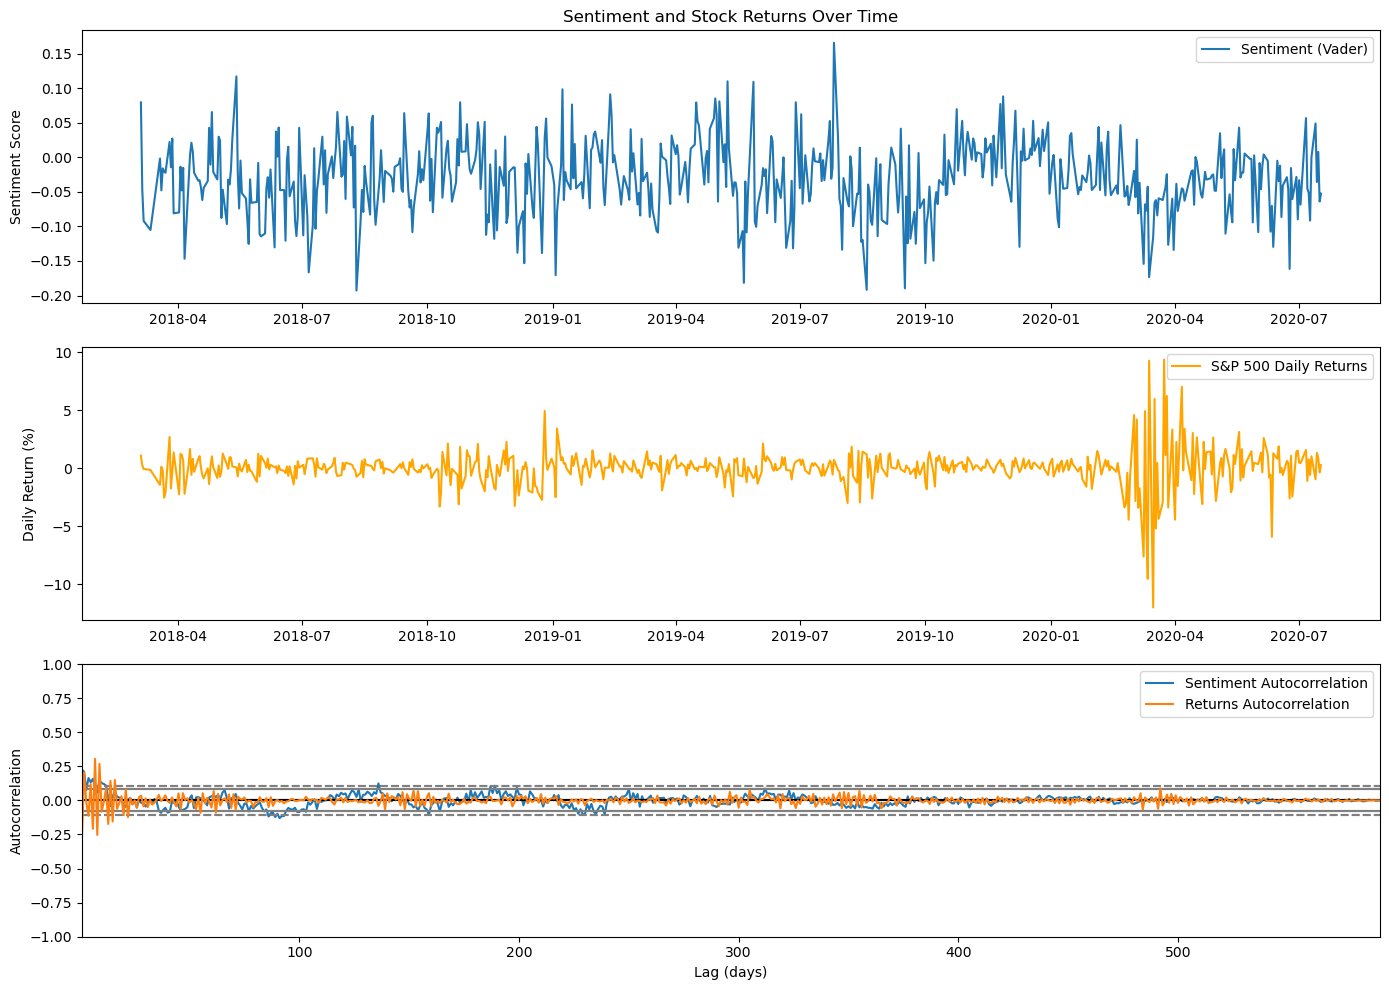

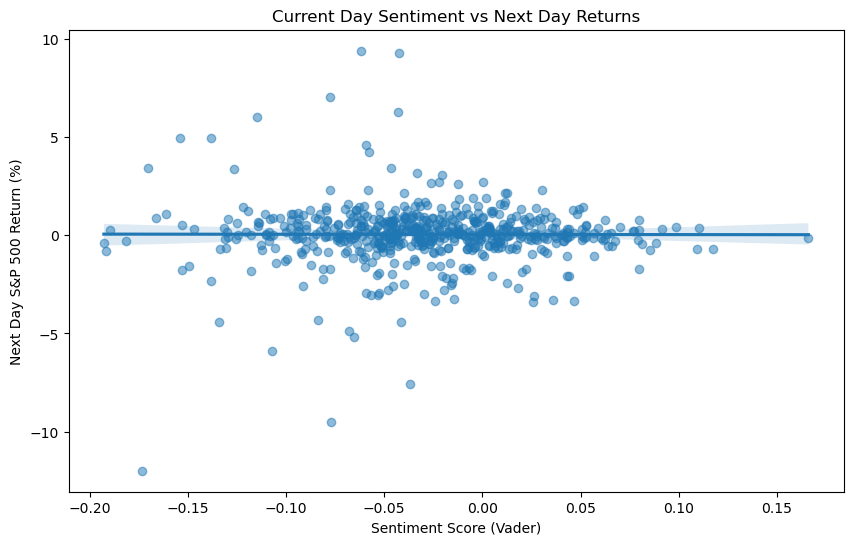

In [8]:
# Main analysis pipeline
def analyze_sentiment_impact(news_df):
    """Complete analysis pipeline"""
    # Step 1: Process sentiment data
    daily_sentiment = process_sentiment_data(news_df)
    
    # Step 2: Get stock data
    stock_data = get_stock_data(daily_sentiment['date'].min(), daily_sentiment['date'].max())
    
    # Step 3: Merge and prepare data
    merged_data = prepare_merged_data(daily_sentiment, stock_data)
    
    # Step 4: Check stationarity
    check_stationarity(merged_data[['headline_vader', 'sp500_return']])
    
    # Step 5: Run Granger causality tests
    run_granger_tests(merged_data, 'headline_vader', 'sp500_return')
    run_granger_tests(merged_data, 'sp500_return', 'headline_vader')
    
    # Step 6: Visualize results
    visualize_results(merged_data)
    
    return merged_data

# Run the analysis
final_results = analyze_sentiment_impact(all_news)

## Final Conclusion

No significant predictive relationship was found in either direction:
- Sentiment does not Granger-cause stock returns.
- Stock returns do not Granger-cause sentiment.

### Implications
- News sentiment (as measured) may not be a strong predictor of stock movements.
- The stock market’s impact on public sentiment is also not statistically significant.

### Potential Next Steps:

1. Try different sentiment sources (e.g., social media, earnings calls).
2. Use alternative sentiment metrics (e.g., word embeddings, deep learning-based sentiment analysis).
3. Incorporate additional financial indicators (e.g., volatility, trading volume).
4. Check for nonlinear relationships using machine learning models.

### Key Findings:

1. Both sentiment scores and stock returns are stationary (p-values < 0.05 from ADF tests), meaning they do not exhibit trends or seasonality that require transformation.

2. Granger causality tests show no significant causal relationship in either direction:
- News sentiment does not significantly predict future stock returns (all p-values > 0.05).
- Stock returns do not significantly impact future sentiment (all p-values > 0.05).

#### Implications
- This suggests that daily financial news sentiment, as measured, does not drive market movements in a predictable way.
- Likewise, market fluctuations do not strongly influence public sentiment in news headlines.
- The stock market may react to broader economic conditions, investor psychology, and fundamental factors rather than sentiment alone.